In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import calinski_harabasz_score, adjusted_rand_score
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, AffinityPropagation
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.model_selection import ParameterGrid
from sklearn.decomposition import PCA

warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning)


# 类别映射 + 处理特殊字符
def map_classes(df, binary=False):
    df_copy = df.copy()
    df_copy['Type'] = df_copy['Type'].str.strip()
    if binary:
        # 二分类：窗口玻璃 vs 非窗口玻璃
        window_types = ['building_windows_float_processed', 'building_windows_non_float_processed', 'vehicle_windows_float_processed']
        df_copy['Target'] = np.where(df_copy['Type'].isin(window_types), 'window', 'non_window')
    else:
        # 多分类：保持原始类别
        df_copy['Target'] = df_copy['Type']
    return df_copy


# 加载数据
train_df = pd.read_csv('./data/glass.data', header=None, names=['RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe', 'Type'], skiprows=1)
test_df = pd.read_csv('./data/glass.test', header=None, names=['RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe', 'Type'], skiprows=1)
# 清理类型列中的点号
train_df['Type'] = train_df['Type'].str.rstrip('.')
test_df['Type'] = test_df['Type'].str.rstrip('.')
combined_df = pd.concat([train_df, test_df], ignore_index=True)
# 查看缺失值
combined_df.info()
# 特征列
features = ['RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe']

# 二分类
combined_data_binary = map_classes(combined_df, True)
# 多分类
combined_data_multi = map_classes(combined_df, False)

X_binary = combined_data_binary[features]
y_binary = combined_data_binary['Target']
X_multi = combined_data_multi[features]
y_multi = combined_data_multi['Target']

# 标准化数据
scaler = StandardScaler()
X_binary_scaled = scaler.fit_transform(X_binary)
X_multi_scaled = scaler.fit_transform(X_multi)


def plot_pca_clustering(X, labels, true_labels, method_name, data_type, n_components=2):
    """绘制PCA降维后的聚类结果"""
    # 执行PCA降维
    pca = PCA(n_components=n_components, random_state=42)
    X_pca = pca.fit_transform(X)

    # 创建子图
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # 子图1：真实标签
    if true_labels is not None:
        unique_true = sorted(np.unique(true_labels))
        colors_true = sns.color_palette("husl", len(unique_true))

        for i, label in enumerate(unique_true):
            mask = true_labels == label
            ax1.scatter(X_pca[mask, 0], X_pca[mask, 1],
                        c=[colors_true[i]], label=label, alpha=0.7, s=50)

        ax1.set_title(f'{data_type} - PCA: True Labels\n'
                      f'Explained Variance: {pca.explained_variance_ratio_.sum():.3f}')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

    # 子图2：聚类结果
    unique_clusters = sorted(np.unique(labels))
    colors_clusters = sns.color_palette("husl", len(unique_clusters))

    for i, cluster in enumerate(unique_clusters):
        mask = labels == cluster
        cluster_label = f'Cluster {cluster}' if cluster != -1 else 'Noise'
        ax2.scatter(X_pca[mask, 0], X_pca[mask, 1],
                    c=[colors_clusters[i]], label=cluster_label, alpha=0.7, s=50)

    ax2.set_title(f'{data_type} - PCA: {method_name} Clustering\n'
                  f'Silhouette: {silhouette_score(X, labels):.3f}')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # 设置坐标轴标签
    for ax in [ax1, ax2]:
        ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.3f})')
        ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.3f})')

    plt.tight_layout()
    plt.show()

    # 打印PCA信息
    print(f"PCA解释方差比: {pca.explained_variance_ratio_}")
    print(f"累计解释方差: {pca.explained_variance_ratio_.sum():.3f}")


# 评估聚类结果
def evaluate_clustering(X, labels, true_labels=None, method_name="", data_type="", plot_pca=True):
    """评估聚类结果"""
    results = {'Method': method_name}

    # 无监督评估指标
    if len(np.unique(labels)) > 1:
        results['Silhouette_Score'] = silhouette_score(X, labels)
        results['Calinski_Harabasz_Score'] = calinski_harabasz_score(X, labels)
        results['N_Clusters'] = len(np.unique(labels))
        results['N_Noise'] = np.sum(labels == -1) if -1 in labels else 0
    else:
        results['Silhouette_Score'] = -1
        results['Calinski_Harabasz_Score'] = -1
        results['N_Clusters'] = len(np.unique(labels))
        results['N_Noise'] = np.sum(labels == -1) if -1 in labels else 0

    # 有监督评估指标（如果有真实标签）
    if true_labels is not None:
        results['Adjusted_Rand_Index'] = adjusted_rand_score(true_labels, labels)

    # PCA可视化
    if plot_pca and len(np.unique(labels)) > 1 and true_labels is not None:
        plot_pca_clustering(X, labels, true_labels, method_name, data_type)

    return results

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RI      214 non-null    float64
 1   Na      214 non-null    float64
 2   Mg      214 non-null    float64
 3   Al      214 non-null    float64
 4   Si      214 non-null    float64
 5   K       214 non-null    float64
 6   Ca      214 non-null    float64
 7   Ba      214 non-null    float64
 8   Fe      214 non-null    float64
 9   Type    214 non-null    object 
dtypes: float64(9), object(1)
memory usage: 16.8+ KB


玻璃数据集聚类分析

二分类聚类分析 (真实类别数: 2)
------------------------------------------------------------

正在调参 kmeans...


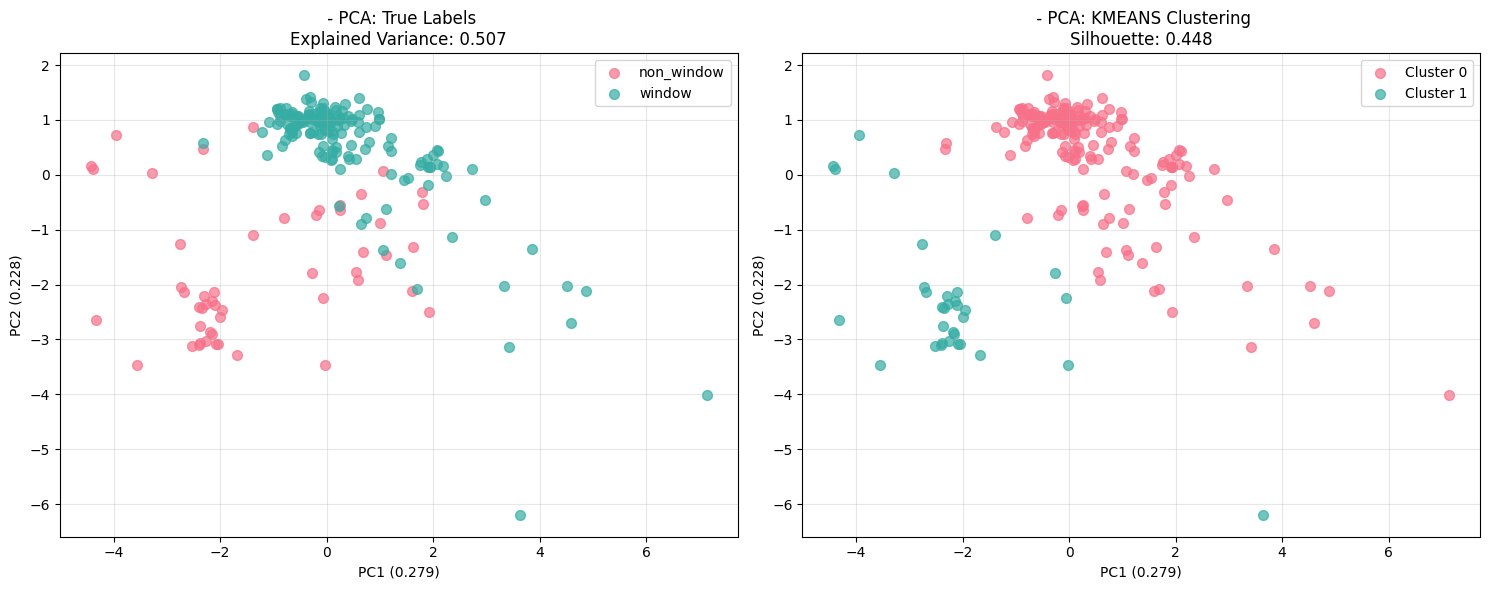

PCA解释方差比: [0.27901819 0.2277858 ]
累计解释方差: 0.507
kmeans - 最佳参数: {'init': 'k-means++', 'n_clusters': 2, 'n_init': 30, 'random_state': 42}
轮廓系数: 0.4475, 调整兰德指数: 0.6092139117511955, 簇数: 2

正在调参 dbscan...


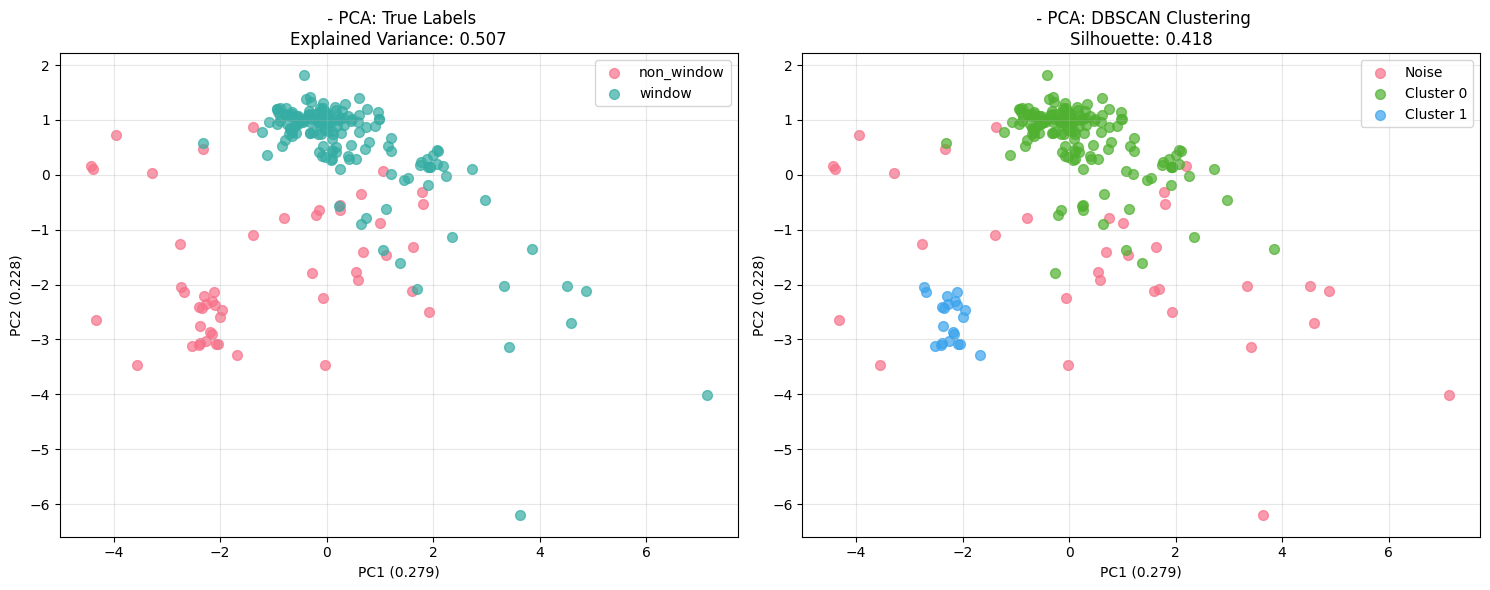

PCA解释方差比: [0.27901819 0.2277858 ]
累计解释方差: 0.507
dbscan - 最佳参数: {'eps': 1.9000000000000001, 'metric': 'euclidean', 'min_samples': 9}
轮廓系数: 0.4181, 调整兰德指数: 0.6657928755232277, 簇数: 3

正在调参 agglomerative...


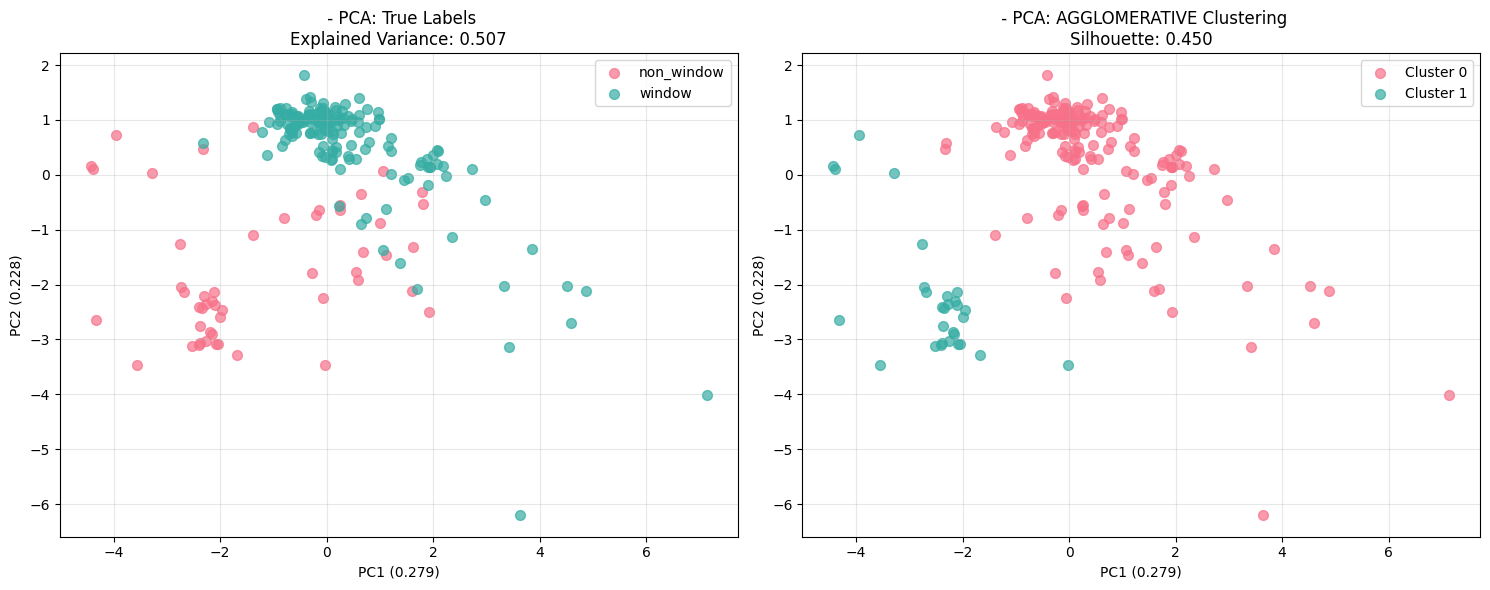

PCA解释方差比: [0.27901819 0.2277858 ]
累计解释方差: 0.507
agglomerative - 最佳参数: {'linkage': 'ward', 'metric': 'euclidean', 'n_clusters': 2}
轮廓系数: 0.4499, 调整兰德指数: 0.5674010746123401, 簇数: 2

正在调参 affinity...


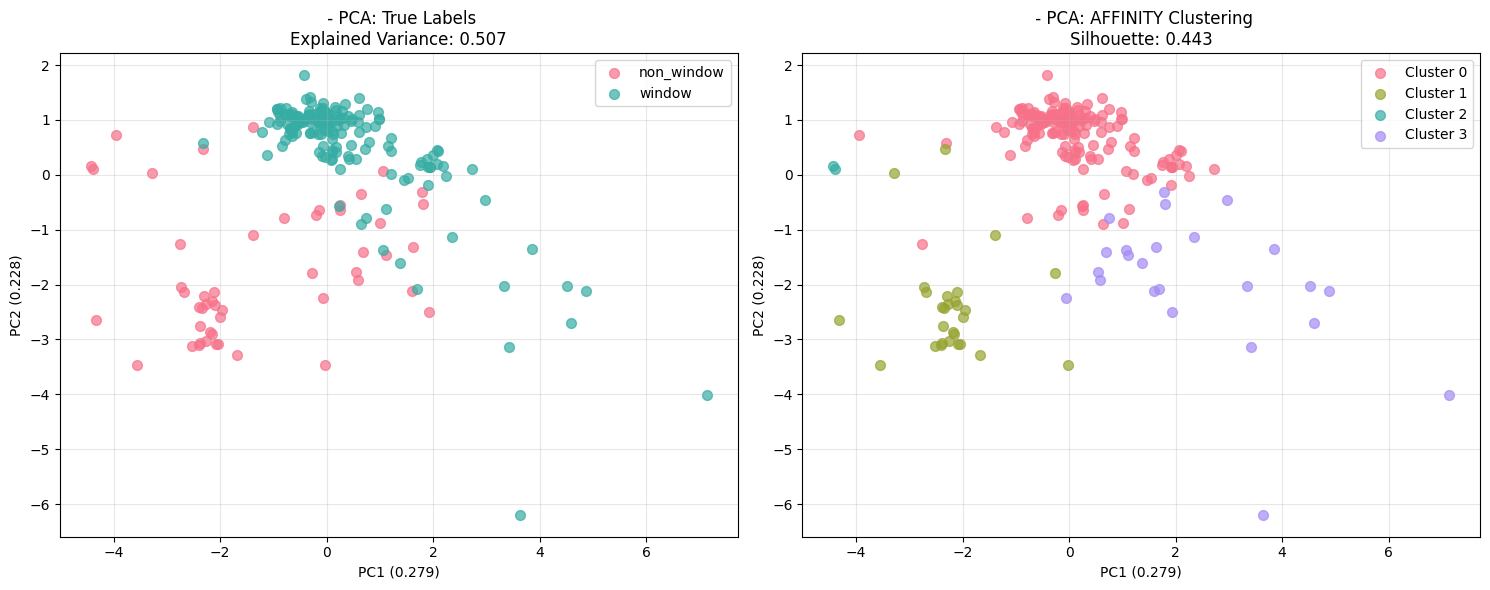

PCA解释方差比: [0.27901819 0.2277858 ]
累计解释方差: 0.507
affinity - 最佳参数: {'convergence_iter': 25, 'damping': 0.9000000000000004, 'max_iter': 200, 'preference': -200, 'random_state': 42}
轮廓系数: 0.4433, 调整兰德指数: 0.5708119829378404, 簇数: 4

二分类最佳聚类方法:
       Method  Silhouette_Score  Calinski_Harabasz_Score  N_Clusters  N_Noise  Adjusted_Rand_Index                                                                                                      Best_Params  Best_Score
AGGLOMERATIVE           0.44992                 54.15404           2        0              0.56740                                                      {'linkage': 'ward', 'metric': 'euclidean', 'n_clusters': 2}     0.48517
       KMEANS           0.44751                 55.52114           2        0              0.60921                                         {'init': 'k-means++', 'n_clusters': 2, 'n_init': 30, 'random_state': 42}     0.49602
     AFFINITY           0.44333                 57.77279           4        0             

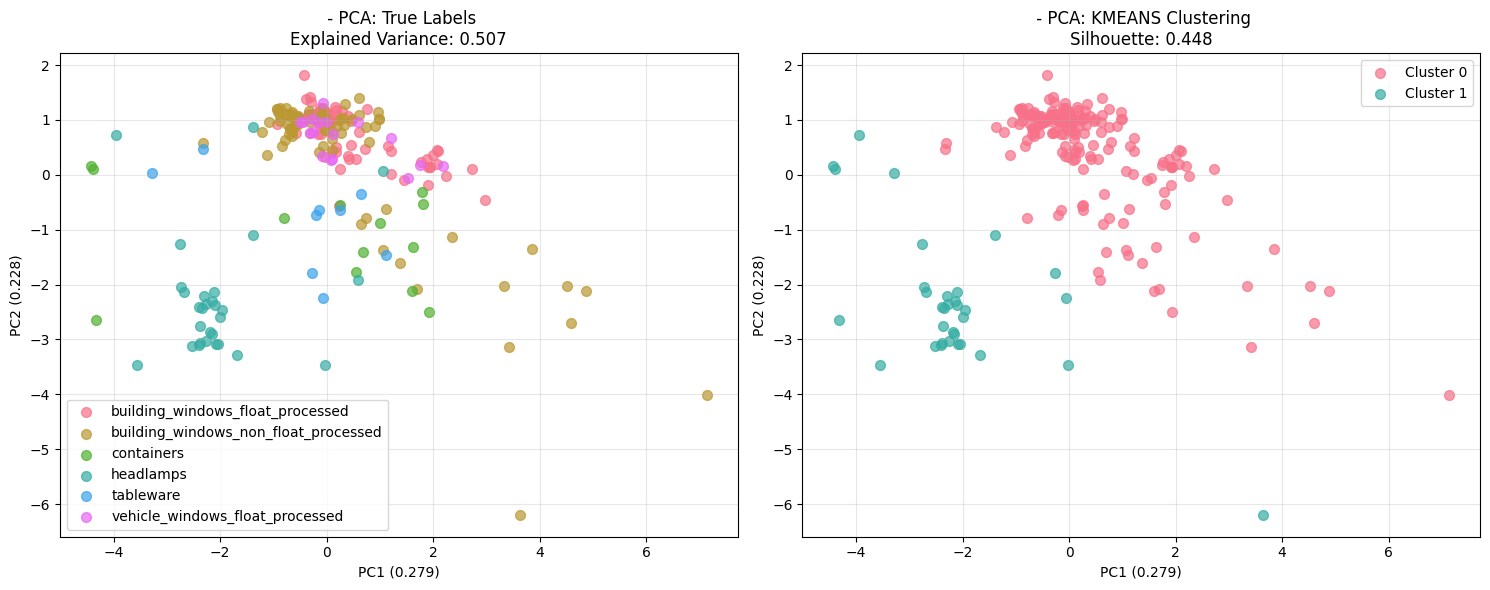

PCA解释方差比: [0.27901819 0.2277858 ]
累计解释方差: 0.507
kmeans - 最佳参数: {'init': 'k-means++', 'n_clusters': 2, 'n_init': 30, 'random_state': 42}
轮廓系数: 0.4475, 调整兰德指数: 0.19295839974924864, 簇数: 2

正在调参 dbscan...


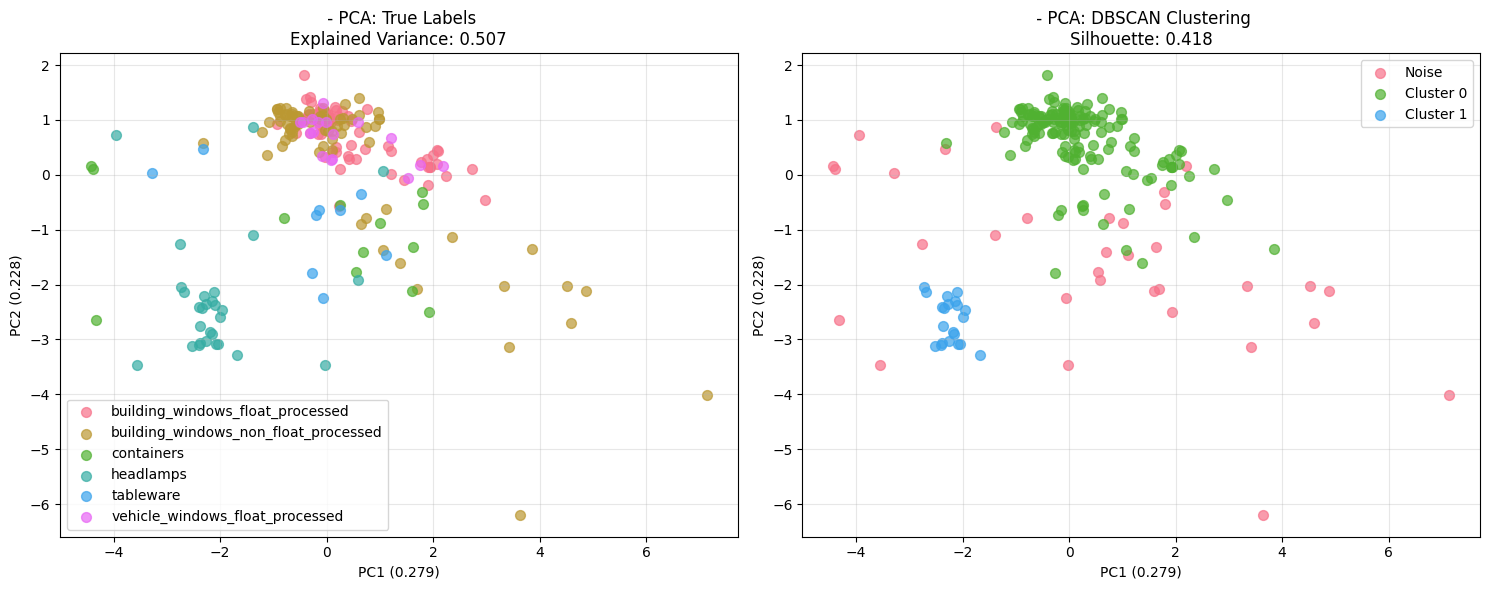

PCA解释方差比: [0.27901819 0.2277858 ]
累计解释方差: 0.507
dbscan - 最佳参数: {'eps': 1.9000000000000001, 'metric': 'euclidean', 'min_samples': 9}
轮廓系数: 0.4181, 调整兰德指数: 0.25813456928486983, 簇数: 3

正在调参 agglomerative...


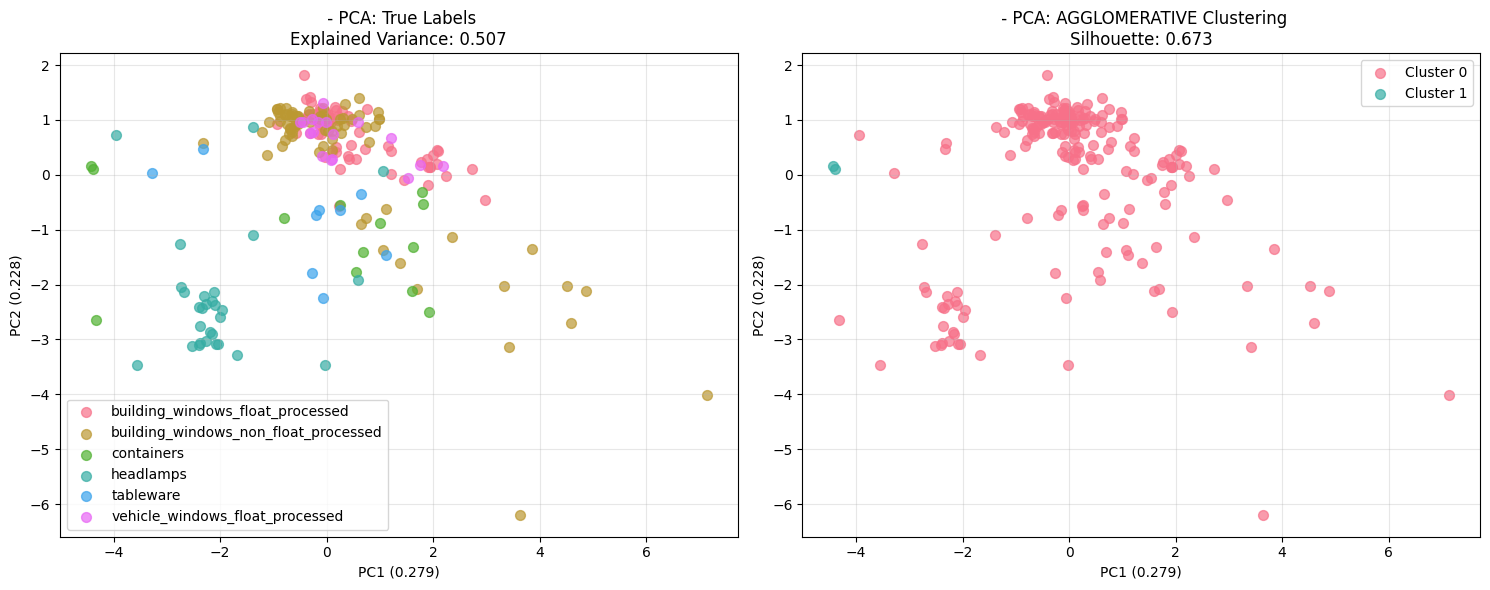

PCA解释方差比: [0.27901819 0.2277858 ]
累计解释方差: 0.507
agglomerative - 最佳参数: {'linkage': 'average', 'metric': 'euclidean', 'n_clusters': 2}
轮廓系数: 0.6735, 调整兰德指数: 0.010578625268392662, 簇数: 2

正在调参 affinity...


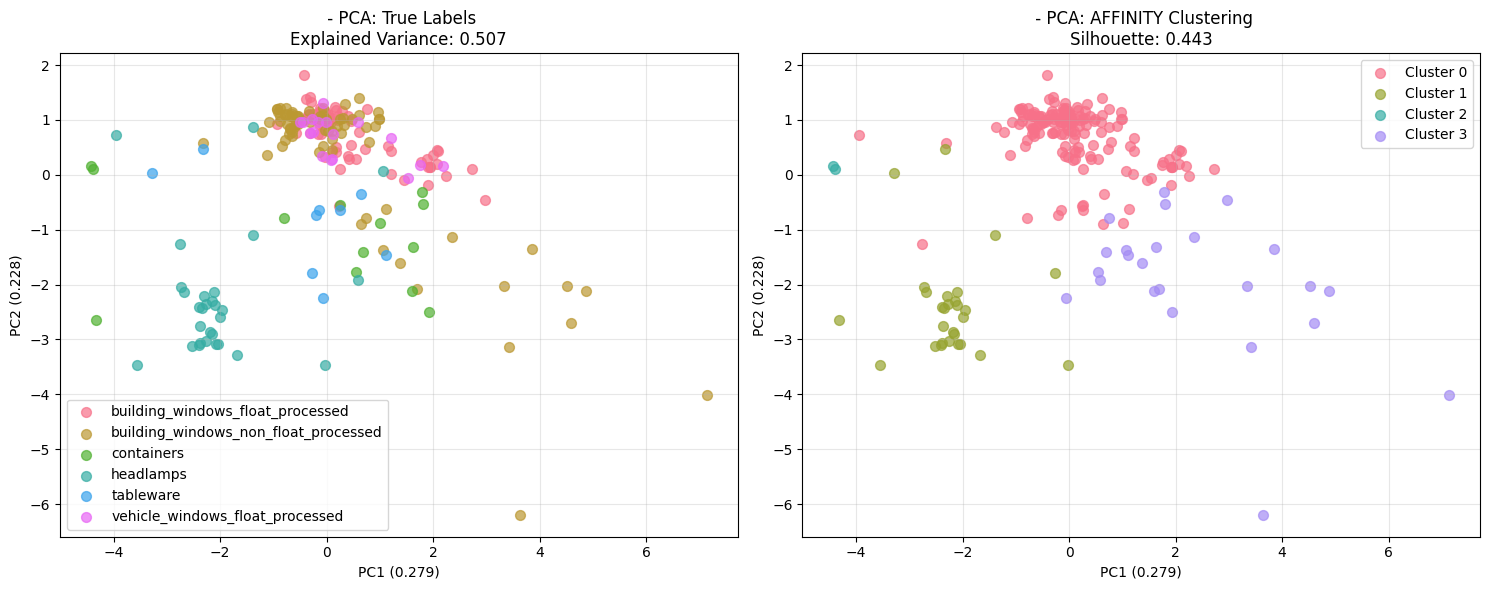

PCA解释方差比: [0.27901819 0.2277858 ]
累计解释方差: 0.507
affinity - 最佳参数: {'convergence_iter': 25, 'damping': 0.9000000000000004, 'max_iter': 200, 'preference': -200, 'random_state': 42}
轮廓系数: 0.4433, 调整兰德指数: 0.21953397181076265, 簇数: 4

多分类最佳聚类方法:
       Method  Silhouette_Score  Calinski_Harabasz_Score  N_Clusters  N_Noise  Adjusted_Rand_Index                                                                                                      Best_Params  Best_Score
AGGLOMERATIVE           0.67350                 25.78488           2        0              0.01058                                                   {'linkage': 'average', 'metric': 'euclidean', 'n_clusters': 2}     0.47462
       KMEANS           0.44751                 55.52114           2        0              0.19296                                         {'init': 'k-means++', 'n_clusters': 2, 'n_init': 30, 'random_state': 42}     0.37115
     AFFINITY           0.44333                 57.77279           4        0            

In [35]:
print("玻璃数据集聚类分析")

# 对二分类和多分类分别进行聚类分析
for data_type, X, X_scaled, y, n_true_clusters in [
    ('二分类', X_binary, X_binary_scaled, y_binary, len(y_binary.unique())),
    ('多分类', X_multi, X_multi_scaled, y_multi, len(y_multi.unique()))
]:
    print(f"\n{data_type}聚类分析 (真实类别数: {n_true_clusters})")
    print("-" * 60)

    all_results = []

    # 聚类方法列表
    methods = ['kmeans', 'dbscan', 'agglomerative', 'affinity']

    for method in methods:
        print(f"\n正在调参 {method}...")

        best_model = None
        best_params = {}
        best_score = -np.inf

        if method == 'kmeans':
            # KMeans 参数网格
            param_grid = {
                'n_clusters': range(2, 9),
                'init': ['k-means++', 'random'],
                'n_init': [10, 20, 30],
                'random_state': [42]
            }
            for params in ParameterGrid(param_grid):
                model = KMeans(**params)
                labels = model.fit_predict(X_scaled)

                # 计算轮廓系数
                if len(np.unique(labels)) > 1:
                    score = silhouette_score(X_scaled, labels)

                    # 如果有真实标签，计算调整兰德指数
                    if y is not None:
                        ari = adjusted_rand_score(y, labels)
                        score = 0.7 * score + 0.3 * ari  # 组合分数

                    if score > best_score:
                        best_score = score
                        best_params = params
                        best_model = model

        elif method == 'dbscan':
            # DBSCAN 参数网格
            param_grid = {
                'eps': np.arange(0.1, 2.0, 0.1),
                'min_samples': range(2, 10),
                'metric': ['euclidean', 'manhattan']
            }
            for params in ParameterGrid(param_grid):
                model = DBSCAN(**params, n_jobs=-1)
                labels = model.fit_predict(X_scaled)

                # 排除所有点都是噪声或只有一个簇的情况
                unique_labels = np.unique(labels)
                n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)

                if n_clusters > 1 and n_clusters < len(X) // 2:
                    score = silhouette_score(X_scaled, labels)

                    if y is not None:
                        ari = adjusted_rand_score(y, labels)
                        score = 0.7 * score + 0.3 * ari

                    if score > best_score:
                        best_score = score
                        best_params = params
                        best_model = model

        elif method == 'agglomerative':
            # 层次聚类参数网格
            param_grid = {
                'n_clusters': range(2, 9),
                'linkage': ['ward', 'complete', 'average', 'single'],
                'metric': ['euclidean', 'manhattan', 'cosine']
            }

            for params in ParameterGrid(param_grid):
                # ward 方法只能使用欧氏距离
                if params['linkage'] == 'ward' and params['metric'] != 'euclidean':
                    continue

                model = AgglomerativeClustering(**params)
                labels = model.fit_predict(X_scaled)

                if len(np.unique(labels)) > 1:
                    score = silhouette_score(X_scaled, labels)

                    if y is not None:
                        ari = adjusted_rand_score(y, labels)
                        score = 0.7 * score + 0.3 * ari

                    if score > best_score:
                        best_score = score
                        best_params = params
                        best_model = model

        elif method == 'affinity':
            # Affinity Propagation 参数网格
            param_grid = {
                'damping': np.arange(0.5, 0.95, 0.05),
                'max_iter': [200, 500, 1000, 2000],
                'convergence_iter': [25, 50, 75, 100],
                'preference': [None, -50, -100, -200],
                'random_state': [42]
            }
            for params in ParameterGrid(param_grid):
                model = AffinityPropagation(**params)
                labels = model.fit_predict(X_scaled)

                if len(np.unique(labels)) > 1 and len(np.unique(labels)) < len(X) // 2:
                    score = silhouette_score(X_scaled, labels)

                    if y is not None:
                        ari = adjusted_rand_score(y, labels)
                        score = 0.7 * score + 0.3 * ari

                    if score > best_score:
                        best_score = score
                        best_params = params
                        best_model = model

        # 评估最佳模型
        if best_model is not None:
            # 预测标签
            labels = best_model.fit_predict(X_scaled)

            # 评估结果
            results = evaluate_clustering(X_scaled, labels, y, method.upper())
            results['Best_Params'] = str(best_params)
            results['Best_Score'] = best_score
            all_results.append(results)

            print(f"{method} - 最佳参数: {best_params}")
            print(f"轮廓系数: {results['Silhouette_Score']:.4f}, "
                  f"调整兰德指数: {results.get('Adjusted_Rand_Index', 'N/A')}, "
                  f"簇数: {results['N_Clusters']}")
        else:
            print(f"{method.upper()} - 未找到有效参数")

    # 显示最佳结果
    if all_results:
        print(f"\n{data_type}最佳聚类方法:")
        results_df = pd.DataFrame(all_results)
        results_df = results_df.sort_values('Silhouette_Score', ascending=False)
        print(results_df.to_string(index=False))

        best_method = results_df.iloc[0]['Method']
        print(f"\nBest Method: {best_method}")